# Visualize a Neural Network


How to build and visualize a (pyTorch) neural network in python.

```
: zach wolpe
: zach.wolpe@medibio.com.au
```

In [3]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchviz import make_dot
from torch import nn
import torch

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader  = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


device = (
    "cuda"      if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)
print('\n', f"Using {device} device", sep='')

100%|██████████| 26421880/26421880 [00:02<00:00, 10857948.04it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 860194.44it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4225001.92it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 29100103.76it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64

Using mps device


In [5]:
# define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x       = self.flatten(x)
        logits  = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
# training configuration
loss_fn     = nn.CrossEntropyLoss()
optimizer   = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y       = X.to(device), y.to(device)
            pred       = model(X)
            test_loss += loss_fn(pred, y).item()
            correct   += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct   /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303717  [    0/60000]
loss: 2.291993  [ 6400/60000]
loss: 2.274285  [12800/60000]
loss: 2.274104  [19200/60000]
loss: 2.251646  [25600/60000]
loss: 2.238723  [32000/60000]
loss: 2.231439  [38400/60000]
loss: 2.204815  [44800/60000]
loss: 2.205823  [51200/60000]
loss: 2.175158  [57600/60000]
Test Error: 
 Accuracy: 54.3%, Avg loss: 2.168243 

Epoch 2
-------------------------------
loss: 2.181835  [    0/60000]
loss: 2.171354  [ 6400/60000]
loss: 2.113728  [12800/60000]
loss: 2.131635  [19200/60000]
loss: 2.085915  [25600/60000]
loss: 2.040959  [32000/60000]
loss: 2.052529  [38400/60000]
loss: 1.981926  [44800/60000]
loss: 1.983985  [51200/60000]
loss: 1.916668  [57600/60000]
Test Error: 
 Accuracy: 61.4%, Avg loss: 1.911124 

Epoch 3
-------------------------------
loss: 1.948401  [    0/60000]
loss: 1.918146  [ 6400/60000]
loss: 1.795349  [12800/60000]
loss: 1.836358  [19200/60000]
loss: 1.743231  [25600/60000]
loss: 1.690770  [32000/600

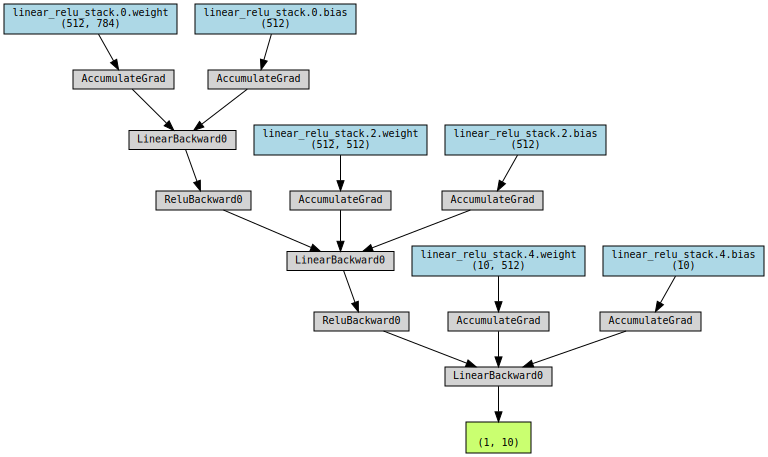

In [9]:
X = torch.randn(1, 1, 28, 28).to(device)
model.eval()
pred = model(X)

make_dot(pred, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")
make_dot(pred, params=dict(list(model.named_parameters())))